In [1]:
# import kent library
import sys
sys.path.insert(0, '/data/critt/shared/Spring19/')

import kent
import importlib
importlib.reload(kent)

<module 'kent' from '/data/critt/shared/Spring19/kent.py'>

In [2]:
import numpy as np
import pandas as pd

In [67]:
cs19 = kent.readTPDDBtables(["PARA19/Tables/"], "*st", path="/data/critt/tprdb/KENT/")

In [68]:
df = cs19.copy()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

### Goal

- To test the hypothesis laid down in the papers BIA, BIA+ and Multilink for Bilingual Translations
- To quantify the lexical access ( the activation of similar words in translator's mind during translation)
- By similar words we mean Orthographic similar words, Semantic similar words and phonological similar words
- Orthographic similar words quantified by Levinshtein's distance
- Semantic similar words are quantified by Word2Vec which produces semanitcally similar words
- To analyse the impact of the Orthographic Similar words and Semantic Similar words on the translator's mind which might impact the *Word Translational Time*
- To apply this theory to our data in TPR DB to analyse the impact on Dur, HTra etc.
- We would take English-Spanish data for our experiment

# Semantic Similarity using Word2Vec
- Load source w2v in English Language
- Load target w2v in Spanish Language
- Create a mappping between source and target language
- The mapping allows us to input a word in english and get its translation (semantically similar words) in Spanish

In [3]:
from gensim.models import KeyedVectors

In [4]:
filename = '/data/critt/shared/w2v/glove/glove.6B.300d.word2vec.txt'
english_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [5]:
filename = '/data/critt/shared/w2v/spanish/SBW-vectors-300-min5.txt'
spanish_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [6]:
english_model.most_similar(positive="carrot")

[('carrots', 0.6997172832489014),
 ('celery', 0.6487882733345032),
 ('onion', 0.5929298400878906),
 ('cucumber', 0.5483486652374268),
 ('diced', 0.5251296758651733),
 ('zucchini', 0.508668839931488),
 ('cauliflower', 0.49913913011550903),
 ('garlic', 0.4979204535484314),
 ('tomato', 0.4880048930644989),
 ('cabbage', 0.4806039035320282)]

In [7]:
spanish_model.most_similar(positive="zanahoria")

[('zanahorias', 0.7926241159439087),
 ('repollo', 0.7743381261825562),
 ('cebolla', 0.7645845413208008),
 ('lechuga', 0.7632054090499878),
 ('apio', 0.7592564821243286),
 ('pimiento', 0.7460507154464722),
 ('cilantro', 0.742472767829895),
 ('tomate', 0.7380776405334473),
 ('culantro', 0.7277785539627075),
 ('morrón', 0.7239552736282349)]

In [8]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
euclidean_distances(spanish_model.get_vector("hombre").reshape(1,-1),english_model.get_vector("man").reshape(1,-1))

array([[5.9634266]], dtype=float32)

In [10]:
cosine_similarity(spanish_model.get_vector("hombre").reshape(1,-1),english_model.get_vector("man").reshape(1,-1))

array([[0.03835413]], dtype=float32)

In [151]:
english_model.most_similar(positive="men")

[('women', 0.7656919956207275),
 ('man', 0.5819568634033203),
 ('soldiers', 0.5340593457221985),
 ('who', 0.5212128758430481),
 ('boys', 0.515128493309021),
 ('young', 0.5093550086021423),
 ('male', 0.5081119537353516),
 ('they', 0.5072554349899292),
 ('girls', 0.5066787004470825),
 ('four', 0.49686184525489807)]

# Translation Matrix generation
- Our assumption is that the Word2Vec models have a linear mapping between them
- We can verify that our assumption is true by plotting words of English and Spanish in 2D space using PCA
- PCA reduces the dimensions using principles of SVD and extracts the principal components.
- If we can build a linear map, then we can project the vectors from English space to Spanish space
- Our solution is that we create a translation matrix and project the word vector from English models to its corresponding word vector in Spanish model
- This way we can get the Spanish translation of the english word. For e.g. the linear map can project "man" to "hombre"
- For example, if we enter "man" in english model, our translation matrix translates this word to "hombre" in Spanish

In [11]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [12]:
english_numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
#english_model[english_numbers]

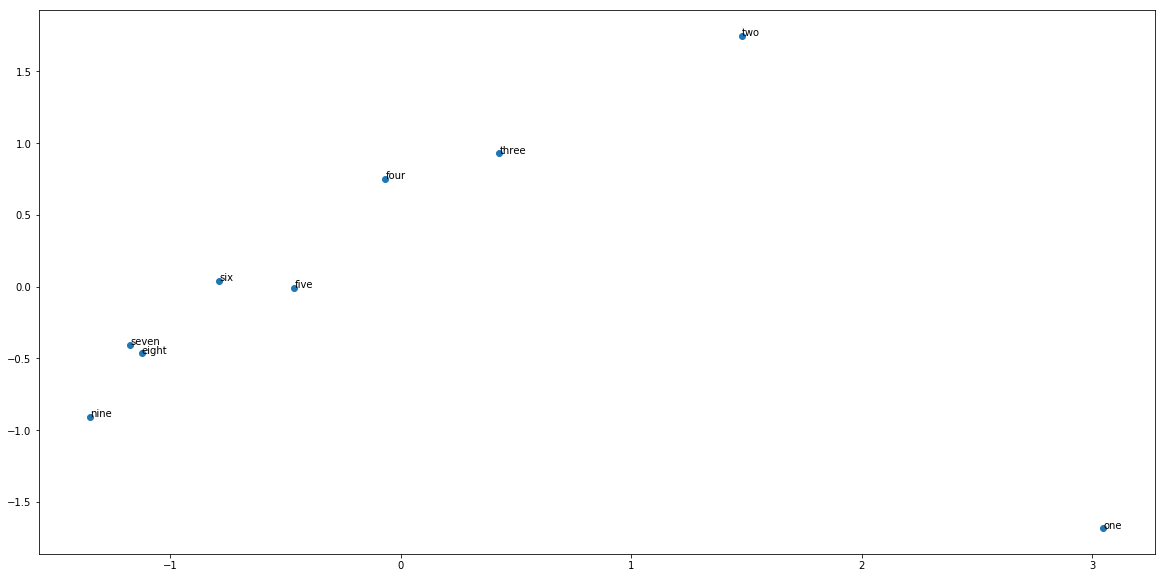

In [13]:
X = english_model[english_numbers]

# fit a 2d PCA model to the vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.figure(figsize=(20,10))
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(english_numbers):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [14]:
spanish_numbers = ["uno", "dos", "tres", "cuatro", "cinco","seis","siete", "ocho", "nueve"]

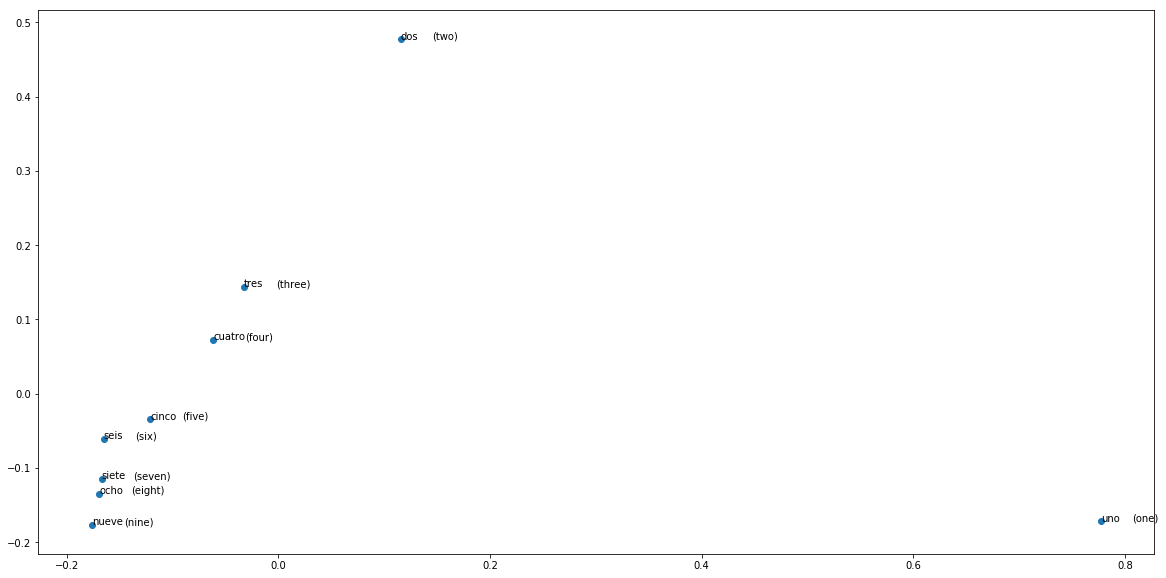

In [15]:
X = spanish_model[spanish_numbers]

# fit a 2d PCA model to the vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
pyplot.figure(figsize=(20,10))
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(spanish_numbers):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
for i, word in enumerate(english_numbers):
    word = "("+word+")"
    pyplot.annotate(word, xy=(result[i, 0]+.03, result[i, 1]))
pyplot.show()

### en_es_trans contains translation EN-ES of 5000 most frequent english words in BNC corpus
- We use these words to train our translation matrix
- I used Google Translation API to get the translation of the words

In [ ]:
from google.cloud import translate
translate_client = translate.Client()

def translate(text, target='es'):
    # The text to translate
    #text = u'you'
    # The target language
    #target = 'es'

    # Translates some text into target language
    translation = translate_client.translate(
        text,
        target_language=target)

    #print(u'Text: {}'.format(text))
    #print(u'Translation: {}'.format(translation['translatedText']))
    return translation['translatedText']

In [16]:
# Imports the json file stored in disk
import json
f = open('top_5000_eng_es_trans.txt','r').read()
en_es_trans = json.loads(f)

In [17]:
# Check if the english word and its corresponding spanish word in the en_es_trans dic is found in the vocabulary of our
# word2vec models english_model and spanish_model
missing_en = 0
missing_es = 0
missing_en_words = []
missing_es_words = []

for k in en_es_trans.keys():
    if k not in english_model.vocab:
        missing_en += 1
        missing_en_words.append(k)
    if en_es_trans.get(k) not in spanish_model.vocab:
        missing_es += 1
        missing_es_words.append(en_es_trans.get(k))
        
print(f"missing_en = {missing_en}\nmissing_es = {missing_es}\nmissing_en_words = {missing_en_words}\nmissing_es_words = {missing_es_words}")

missing_en = 11
missing_es = 242
missing_en_words = ['bquo', 'equo', 'mdash', 'rsqb', 'lsqb', 'eacute', 'rehy', 'egrave', 'uuml', 'aacute', 'ouml']
missing_es_words = ['bquos', 'asi que', 'acerca de', 'me gusta', 'antes de', 'Hellip', 'sin embargo', 'otra vez', 'en contra', 'alguna cosa', 'ya que', 'por qué', 'De Verdad', 'a pesar de que', 'más bien', 'a menudo', 'una vez', 'ya sea', 'rsqb', 'lsqb', 'él mismo', 'cualquier cosa', 'ya sea', 'la carretera', 'a.m', 'parte superior', 'Gran Bretaña', 'a través de', 'Por supuesto', 'a lo largo', 'sí mismo', 'sí mismos', 'por lo tanto', 'fuera de', 'a veces', 'en efecto', 'Reino Unido', 'más temprano', 'sí misma', 'Art º', 'A pesar de', 'en lugar', 'Por favor', 'lo que sea', 'S t', 'en todo', 'mí mismo', 'con rapidez', 'de todas formas', 'más allá', 'se ve', 'del Norte', 'a no ser que', 'lo siento', 'tú mismo', 'el respeto', 'tal vez', 'la licenciatura', 'en pie', 'ha fallado', 'se mantuvo', 'más viejo', 'de otra manera', 'la seguridad', 'de a

In [18]:
pairs = pd.DataFrame({"english":list(en_es_trans.keys()),"spanish":list(en_es_trans.values())})

In [19]:
pairs.head()

,english,spanish
0,the,la
1,of,de
2,and,y
3,to,a
4,a,una


In [20]:
# Remove the missing words from the dictionary
missing = 0
for n in range (len(pairs)):
	if pairs['english'][n] not in english_model.vocab or pairs['spanish'][n] not in spanish_model.vocab:
		missing = missing + 1
		pairs = pairs.drop(n)

pairs = pairs.reset_index(drop = True)
print(f"Missing = {missing}")

Missing = 247


In [21]:
pairs['vector_english'] = [english_model[pairs['english'][n]] for n in range (len(pairs))]
pairs['vector_spanish'] = [spanish_model[pairs['spanish'][n]] for n in range (len(pairs))]

### Generating Translation Matrix
- After removing missing words, total 4753 words remained in the dic
- Used first 4400 word pairs to generate the translation matrix
- Remaining words are kept to test our translation matrix

In [143]:
source_training_set = pairs['vector_english'][:4400]
target_training_set = pairs['vector_spanish'][:4400]

matrix_train_source = pd.DataFrame(source_training_set.tolist()).values
matrix_train_target = pd.DataFrame(target_training_set.tolist()).values

print('Generating translation matrix')

# Matrix W is given in  http://stackoverflow.com/questions/27980159/fit-a-linear-transformation-in-python
translation_matrix = np.linalg.pinv(matrix_train_source).dot(matrix_train_target).T
print('Generated translation matrix')

Generating translation matrix
Generated translation matrix


In [144]:
# Display the english word and its spanish projection
def display_spanish_translations(source_words, topn=5):
    trans = {}
    for source_word in source_words:
        s_lower = source_word.lower()
        #source_word =  pairs['english'][word_num]
        #translations = top_translations_list(pairs['english'][word_num]) 
        try:
            translations = spanish_model.similar_by_vector(translation_matrix.dot(english_model[s_lower]),topn=5)
        except KeyError:
            translations = []
        if translations:
            translations = [trans[0] for trans in translations]
        #print(source_word, translations, en_es_trans.get(source_word))
        trans[source_word] = translations
    return trans

# Gensim Translation Matrix Generation

In [146]:
from gensim.models import translation_matrix as tm

In [147]:
trans_model = tm.TranslationMatrix(english_model, spanish_model)

In [148]:
word_pairs = list(zip(pairs['english'][:4400],pairs['spanish'][:4400]))

In [149]:
trans_model.train(word_pairs)

In [166]:
trans_model.translate("man")

/usr/local/lib64/python3.6/site-packages/gensim/models/translation_matrix.py:313: UserWarning: The parameter source_lang_vec isn't specified, use the model's source language word vector as default.
  "The parameter source_lang_vec isn't specified, "
/usr/local/lib64/python3.6/site-packages/gensim/models/translation_matrix.py:320: UserWarning: The parameter target_lang_vec isn't specified, use the model's target language word vector as default.
  "The parameter target_lang_vec isn't specified, "


OrderedDict([('man',
              ['Zeberdee', 'hombre', 'Agonizando', 'Pegador', 'Laginestra'])])

In [165]:
spanish_model.similar_by_vector(translation_matrix.dot(english_model["sociology"]),topn=5)

[('sociología', 0.848386287689209),
 ('psicología', 0.7639850974082947),
 ('antropología', 0.7606707811355591),
 ('politología', 0.7320208549499512),
 ('filosofía', 0.727601170539856)]

In [24]:
transl = display_spanish_translations(pairs.iloc[4401:4753]['english'].tolist())

In [25]:
spanish_transl = pairs.iloc[4401:4753]['spanish'].tolist()

In [26]:
ll = list(transl.items())
for i in range(0,len(transl.items())):
    print(f"{ll[i]} --> {spanish_transl[i]}")

('divide', ['dividir', 'ocidentales', 'balcanizada', 'Sprogø', 'antipodas']) --> dividir
('jews', ['judíos', 'galut', 'askenazis', 'jerosolimitanos', 'Yamnia']) --> judios
('republican', ['derechizado', 'antigolpistas', 'Antimasónico', 'gaitanista', 'alvearismo']) --> republicano
('kit', ['kit', 'PSION', 'heramientas', 'MyWay', 'Printrbot']) --> equipo
('merchant', ['comerciante', 'convoyar', 'émporos', 'Skouloudis', 'convoyando']) --> comerciante
('workshop', ['taller', 'Mourlot', 'lutheria', 'luthería', 'talleres']) --> taller
('evans', ['Vece', 'Gillooly', 'Tuchi', 'DeServio', 'Pillips']) --> evans
('consensus', ['consenso', 'convecimiento', 'bipartidario', 'automarginarse', 'PcA']) --> consenso
('recalled', ['Grzebski', 'Yeswit', 'Alexievich', 'vendara', 'Nomsa']) --> recordado
('midnight', ['medianoche', 'noche', 'mediodía', 'sábado', 'mañana']) --> medianoche
('mills', ['Hilandería', 'Nicaro', 'fábricas', 'tejerías', 'trefilerías']) --> molinos
('essence', ['esencia', 'impermanen

In [168]:
eng_socio = translation_matrix.dot(english_model['sociology'])

In [169]:
spa_socio = spanish_model['sociologia']

In [175]:
eng_socio.shape

(300,)

In [172]:
eng_socio.shape

(300,)

In [173]:
cosine_similarity(eng_socio.reshape(1,-1),spa_socio.reshape(1,-1))

array([[0.48173132]])

In [312]:
hits = 0
print(len(transl.keys()))
for key in transl.keys():
    t = transl.get(key)
    t = [tt.lower() for tt in t]
    #print(type(t))
    if (en_es_trans.get(key).lower() in t):
        hits +=1
print(f"hits = {hits}")

352
hits = 166


### Use in BML12 study

In [27]:
# read the BML study data
stdf = kent.readTPDDBtables(['BML12/Tables/'], "*st", path='/data/critt/tprdb/TPRDB/')
source_words = set(stdf['SToken'].tolist())

In [28]:
source_words_spanish = display_spanish_translations(source_words)

In [201]:
import re
def sourcetargetsimilarity(row,metric="cosine"):
    if metric == "cosine":
        max_sim = 0.0
    elif metric == "euclidean":
        max_sim = 9999.99
    stoken = row['SToken']
    tgroup = row['TGroup']
    
    # pattern to match only alphabets and _
    pattern = re.compile(r'[a-zA-Z_]{'+str(len(tgroup))+'}')
    """
    if not re.match(pattern, tgroup):
        return max_sim
    if not stoken.isalpha():
        return max_sim
    """
    try:
        #translations = spanish_model.similar_by_vector(translation_matrix.dot(english_model[stoken.lower()]),topn=1)
        english_vector = translation_matrix.dot(english_model[stoken.lower()])
    except KeyError:
        translations = [('', 0.0)]
        print("Error11")
        return max_sim
    #print(english_vector)    
    #spanish_translation = translations[0][0]
    #if not spanish_translation:
        #return max_sim
    ttokens = []
    if tgroup != '---':
        ttokens = tgroup.split('_')
    for ttoken in ttokens:
        
        try:
            #print(f"ttoken = {ttoken}")
            #english_vector = spanish_model.get_vector(spanish_translation)
            spanish_vector = spanish_model.get_vector(ttoken)
            if metric == "cosine":
                sim = cosine_similarity(english_vector.reshape(1,-1),spanish_vector.reshape(1,-1))
                sim = sim[0][0]
                #print(f"stoken: {stoken}, ttoken: {ttoken}, sim: {sim}")
                if sim > max_sim:
                    max_sim = sim
            elif metric == "euclidean":
                sim = euclidean_distances(english_vector.reshape(1,-1),spanish_vector.reshape(1,-1))
                sim = sim[0][0]
                if sim < max_sim:
                    max_sim = sim
        except KeyError:
            print(f"[WARN] No matching vector for word: {ttoken}")
    return max_sim

In [207]:
stdf['trans_sim_euc1'] = stdf.apply(lambda row: sourcetargetsimilarity(row, metric="euclidean"), axis=1)

[WARN] No matching vector for word: .
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: (
[WARN] No matching vector for word: 1798
[WARN] No matching vector for word: -
[WARN] No matching vector for word: 1857
[WARN] No matching vector for word: )
[WARN] No matching vector for word: 1838
[WARN] No matching vector for word: (
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: )
[WARN] No matching vector for word: (
[WARN] No matching vector for word: )
[WARN] No matching vector for word: .
[WARN] No matching vector for word: -
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: -
[WARN] No matching vector for word: .


[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 31.300
[WARN] No matching vector for word: 17
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 
[WARN] No matching vector for

[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: atracidades
[WARN] No matching vector for word: atracidades
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: desarrolados
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: emixiones
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .

[WARN] No matching vector for word: .
[WARN] No matching vector for word: 60
[WARN] No matching vector for word: 100
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: -
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: -
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: -
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for w

[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 60
[WARN] No matching vector for word: 100
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: -
[WARN] No matching vector for word: -
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No

[WARN] No matching vector for word: 1857
[WARN] No matching vector for word: )
[WARN] No matching vector for word: 1838
[WARN] No matching vector for word: (
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: )
[WARN] No matching vector for word: (
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: )
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: 19
[WARN] No matching vector 

[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: (
[WARN] No matching vector for word: 1798
[WARN] No matching vector for word: -
[WARN] No matching vector for word: 1857
[WARN] No matching vector for word: )
[WARN] No matching vector for word: 1838
[WARN] No matching vector for word: (
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: )
[WARN] No matching vector for word: (
[WARN] No matching vector for word: )
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 31.300
[WARN] No matching vector for word: 17
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching 

[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: (
[WARN] No matching vector for word: 1798
[WARN] No matching vector for word: -
[WARN] No matching vector for word: 1857
[WARN] No matching vector for word: )
[WARN] No matching vector for word: 1838
[WARN] No matching vector for word: socious
[WARN] No matchi

[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 60
[WARN] No matching vector for word: 100
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: enfemero
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 32
[WARN] No matching vector for word: 32
[WARN] No matching vector for word: 32
[WARN] No matching vector for word: 2002
[WARN] No matching vector for word: .
[WARN] No matching vector for word

[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 31.300
[WARN] No matching vector for word: 17
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 32
[WARN] No matching vector for word: 32
[WARN] No matching vector for word: 32
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: 2002
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vec

[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: -
[WARN] No matching vector for word: -
[WARN] No matching vector for word: -
[WARN] No matching vector for word: -
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word

Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: 19
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: 
[WARN] No matching vector for word: encuñado
[WARN] No matching vector for word: encuñado
[WARN] No matching vector for word: (
[WARN] No matching vector for word: 1798
[WARN] No matching vector for word: -
[WARN] No matching vector for word: 1857
[WARN] No matching vector for word: )
[WARN] No matching

[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 30
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: 31.300
[WARN] No matching vector for word: 17
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: ,
Error11
Error11
[WARN] No matching vector for word: .
[WARN] No matching vector for word: ,
[WARN] No matching vector for word: .
[WARN] No matching vector for word: .
[WARN] No matching vector for word: reáceos
[WARN] No matching vector for word: reáceos
[WARN] No match

### Correlation Analysis

In [206]:
stdf[(stdf.trans_sim > 0)][['HTra', 'trans_sim']].corr()

,HTra,trans_sim
HTra,1.000000,-0.239683
trans_sim,-0.239683,1.000000


In [205]:
stdf[(stdf.trans_sim_cosine1 > 0)][['HTra', 'trans_sim_cosine1']].corr()

,HTra,trans_sim_cosine1
HTra,1.000000,-0.324612
trans_sim_cosine1,-0.324612,1.000000


In [ ]:
stdf['trans_sim_euclidean'] = stdf.apply(lambda row: sourcetargetsimilarity(row, metric="euclidean"), axis=1)

In [208]:
stdf[(stdf.trans_sim_euc1 < 9999)][['trans_sim_euc1','HTra']].corr()

,trans_sim_euc1,HTra
trans_sim_euc1,1.000000,0.329362
HTra,0.329362,1.000000
